# Which version of the website should you use?

**James Morgan (jhmmorgan)**

_2022-07-27_

## 📖 Background
You work for an early-stage startup in Germany. Your team has been working on a redesign of the landing page. The team believes a new design will increase the number of people who click through and join your site.

### The Task
They have been testing the changes for a few weeks and now they want to measure the impact of the change and need you to determine if the increase can be due to random chance or if it is statistically significant.

## 📋 Testing the changes
The team have created a new landing page (called a treatment) and new images.  When customers land on the website, they will randomly be assigned 
* Either the new or old landing page
* Either the new or old set of images

We therefore have 4 groups of customers
* user group **A**: saw the **new** version of the landing page, with **new** set of images.
* user group **B**: saw the **new** version of the landing page, with **old** set of images.
* user group **C**: saw the **old** version of the landing page, with **new** set of images.
* **Control** user group: saw the **old** version of both landing page and set of images.

---
## 📊 Outcome
Following several weeks of testing, we can easily identify, with confidence that to get the highest conversion, we should use:
* The new treatment (the new version of the landing page); and 
* The old set of images

These were the customers in **Group B**.  There is an approx 1.3% uplift in conversion in this group, over the control group.

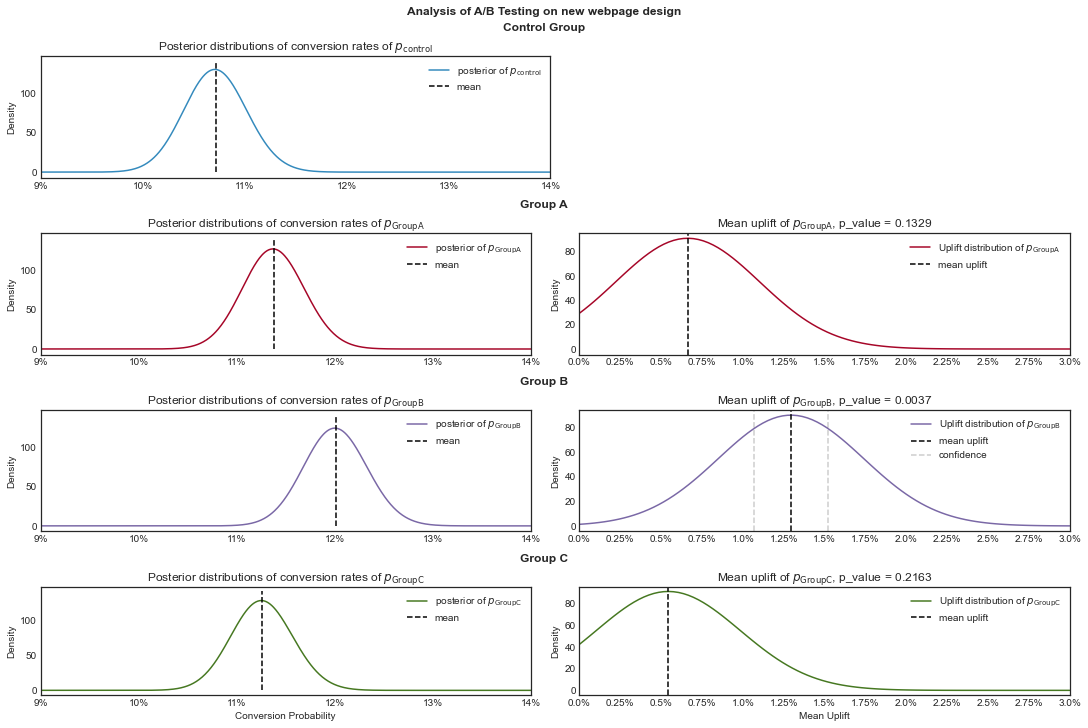

This has been confirmed through multiple methods of testing.

**Group A**
The chance of Group A customers having a better conversion than the control group is 93.6% (through Baysian testing), however we can't rule out that the increased conversion was due to random chance (Frequentist testing). 

**Group B**
The chance of Group B customers having a better conversion than the control group is 99.7% (through Baysian testing), and it's significantly unlikey that the increased conversion is due to random chance (Frequentist testing).

**Group C**
The chance of Group C customers having a better conversion than the control group is 89.6% (through Baysian testing), however like Group A, we can't rule out that the increased conversion was due to random chance (Frequentist testing).
 Expected loss of 0.000222 is below our loss threshold. 


**Please keep reading to understanding how we've come to this conclusion.**

---
---
## 📚 Libraries
For this to work, we'll need to load a number of libaries to perform various statistical modelling and data visualisation.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import beta

import seaborn as sns
import matplotlib.pyplot as plt

from utils import *

In [2]:
plt.style.use('seaborn-white')
BMH_COLORS = ['#348ABD', '#A60628', '#7A68A6', '#467821']

np.random.seed(44)

---
## 💾 The data
The team assembled the following file:

**Redesign test data**
* "treatment"  - "yes" if the user saw the new version of the landing page, no otherwise.
* "new_images" - "yes" if the page used a new set of images, no otherwise.
* "converted"  - 1 if the user joined the site, 0 otherwise.
The control group is those users with "no" in both columns: the old version with the old set of images.

In [3]:
print2.heading("The head of the dateframe")
df = pd.read_csv('./data/redesign.csv')
df.head()

The head of the dateframe


,treatment,new_images,converted
0,yes,yes,0
1,yes,yes,0
2,yes,yes,0
3,yes,no,0
4,no,yes,0


In [4]:
print2.heading("Do we have any missing data?")
df.isnull().any()

Do we have any missing data?


treatment     False
new_images    False
converted     False
dtype: bool

We'll need to convert our **treatment** and **new_images** columns from "yes"/"no" to numeric 1's and 0's.

In [5]:
df['treatment'] = df.treatment.map({'yes': 1, 'no': 0})
df['new_images'] = df.new_images.map({'yes': 1, 'no': 0})
print2.heading("Numeric description of our dataframe")
df.describe()

Numeric description of our dataframe


,treatment,new_images,converted
count,40484.000000,40484.000000,40484.000000
mean,0.500000,0.500000,0.113353
std,0.500006,0.500006,0.317028
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.500000,0.500000,0.000000
75%,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000


Looking at the summary statistics, we see that the dataset is balanced in every way, 50% of the dataset has a treatment and 50% does not; similarly for new_images. In fact, it is balanced across all four groups that we have:

1. Group A: has treatment and has new_images.
2. Group B: has treatment, but no new_images.
3. Group C: no treatment, but has new_images.
the  group: no treatment and no new_images.
Also, observe that the conversion rate across all groups have a mean of 11.3% with a sample standard deviation of 31.7% (which is quite large!).

In [6]:
def grouping(row):
    treatment  = row.treatment
    new_images = row.new_images
    if treatment and new_images:
        return 'A'
    elif treatment and not new_images:
        return 'B'
    elif not treatment and new_images:
        return 'C'
    return 'control'

df['group'] = df.apply(grouping, axis=1)

print2.heading("Size of each group")
print(df.groupby("group").size())
print()
print2.heading("Head of our dataframe, with assigned groups")
df.head()

Size of each group
group
A          10121
B          10121
C          10121
control    10121
dtype: int64

Head of our dataframe, with assigned groups


,treatment,new_images,converted,group
0,1,1,0,A
1,1,1,0,A
2,1,1,0,A
3,1,0,0,B
4,0,1,0,C


---
## Analysis of the conversion rates for each of the four groups

In [7]:
successess = df.groupby("group").converted.sum()# / df.groupby("group").size()
failures   = df.groupby("group").size() - successess
conversion_df = successess / df.groupby("group").size()

print2.heading("Conversion Rate for each of our 4 groups")
print(conversion_df)

Conversion Rate for each of our 4 groups
group
A          0.113724
B          0.120047
C          0.112538
control    0.107104
dtype: float64


We can see that the 3 groups all have a higher conversion rate than our control group, with Group B being the highest.
However, how much of this is due to random chance and what is the probility that a group will perform better than the control group?

This is where our A/B testing comes useful.  We have two approachs:
* Frequentist
* Bayesian

In a **frequentist** model, probability is the limit of the relative frequency of an event after many trials. In other words, this method calculates the probability that the experiment would have the same outcomes if you were to replicate the same conditions again. This model only uses data from the current data when evaluating outcomes.

When applying frequentist statistics we use the p-value. A p-value is the calculated probability of obtaining an effect at least as extreme as the one in our data, assuming the truth of a null hypothesis. For example, a small p-value means that there is a small chance that our results could be random. A large p-value means that our results have a high probability of being random and not due to any changes we made on the website. So, the smaller the p-value, the more statistically significant our results.

With **Bayesian** statistics, probability expresses a degree of belief in our changes. This method is different from the frequentist methodology in a number of ways. One of the big differences is that probability actually expresses the chance of our conversion happening. A Bayesian methodology will tell us the probability that a change is better than before or vice versa. 

---

## Frequentsist A/B Testing

For our frequentist A/B testing, we assume that any increase in conversion is due to random chance. We then try to disprove this hypthesis.  Our null hypothesis is:
> Any uplift in conversion seen in the new version of the landing page, or by using a new set of images is through random chance.

The uplift is the difference in conversion between a given group and our control group.  For example, if our control group saw a conversion of 10% and our group saw a conversion of 12%, then the uplift is 2%.

We'll need to calculate the p_value for each of our groups.  The p-value is the probability of observing a value as or more extreme than the observed value under our null hypothesis. If this value is low, assuming we have enough observations, then there is a low probability that our null hypothesis is true. 

* Our significant level is **0.05**
* Our confidence interval is **0.95%**

### Are the results statistically significant?

In [8]:
def conversion(group):
    successess = group.sum()
    conversion = successess / len(group)
    return conversion

def lift(control, test):
    return conversion(test) - conversion(control)

def get_ci(value, cl, sd):    
    loc = stats.norm.ppf(1 - cl/2)
    rng_val = stats.norm.cdf(loc - value/sd)

    lwr_bnd = value - rng_val
    upr_bnd = value + rng_val 
  
    return_val = (lwr_bnd, upr_bnd)
    return(return_val)

def get_pvalue(control_conversion, test_conversion, control_size, test_size, rounded = None):  
    lift =  -abs(test_conversion - control_conversion)

    scale_one = control_conversion * (1 - control_conversion) * (1 / control_size)
    scale_two = test_conversion * (1 - test_conversion) * (1 / test_size)
    scale_val = (scale_one + scale_two)**0.5

    p_value = 2 * stats.norm.cdf(lift, loc = 0, scale = scale_val )

    if isinstance(rounded, int):
        p_value = round(p_value, rounded)
    return p_value

def statisical_tests(control, test):
    cont_conv   = conversion(control)
    test_conv   = conversion(test)

    cont_size   = len(control)
    test_size   = len(test)

    lift_mean     = lift(control, test)
    lift_variance = (1 - test_conv) * test_conv / test_size + (1 - cont_conv) * cont_conv / cont_size
    lift_sd       = lift_variance**0.5
    
    
    confidence_interval = get_ci(lift_mean, 0.95, lift_sd)    
    
    p_value = get_pvalue(cont_conv, test_conv, cont_size, test_size, rounded = 4)
    
    return p_value, lift_mean, lift_sd, confidence_interval


def generate_plot(ax, x, data, color, group):

    p_value, lift_mean, lift_sd, confidence_interval = data
    
    ax.set_title("Mean uplift of $p_{\mathrm{" + group + "}}$, p_value = " + str(p_value))
    
    lwr_ci, upr_ci = confidence_interval
    y = stats.norm.pdf(x, lift_mean, lift_sd)
    
    ax.plot(x, y, label = 'Uplift distribution of $p_{\mathrm{' + group + '}}$', color = color)
    ax.axvline(lift_mean, color = "black",  linestyle = "--", label = "mean uplift")
    
    if (lwr_ci > np.min(x)) | (upr_ci < np.min(x)):
        ax.axvline(x = lwr_ci, color = 'black', linestyle = "--", alpha = 0.2, label = "confidence")
        ax.axvline(x = upr_ci, color = 'black', linestyle = "--", alpha = 0.2)
    
    ax.legend()
    ax.set_ylabel('Density')

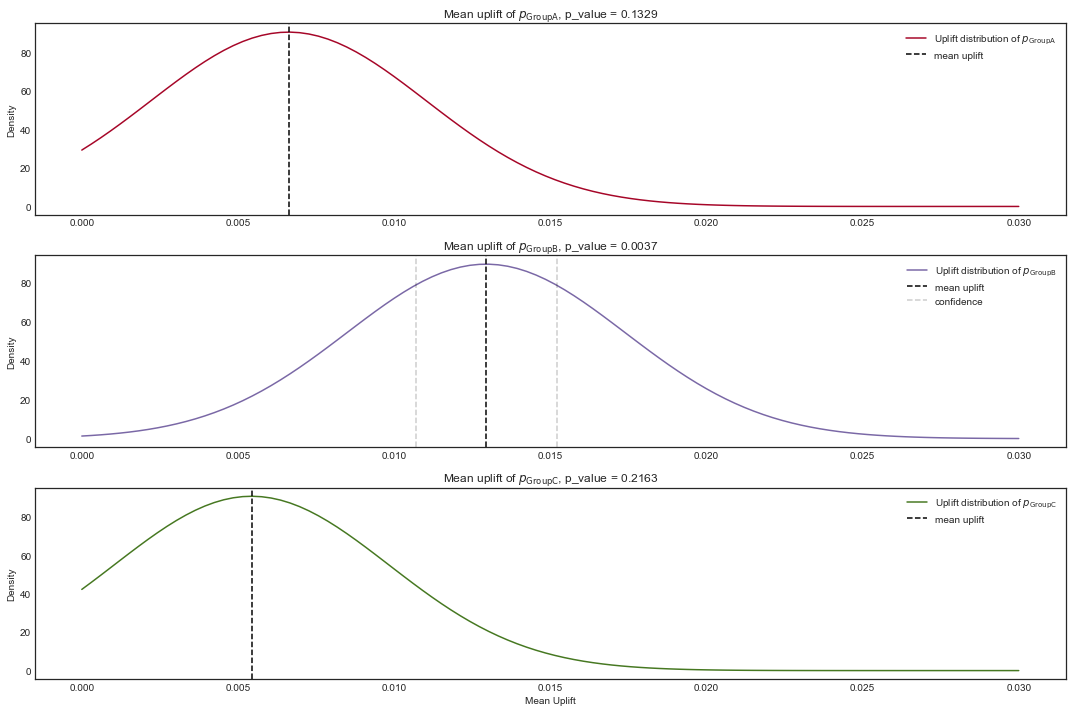

In [9]:
fig, ax = plt.subplots(3, 1, figsize=(15, 10))

x = np.linspace(0, 0.03, 100)

data = statisical_tests(df[df.group == "control"].converted, df[df.group == "A"].converted)
generate_plot(ax[0], x, data, color = BMH_COLORS[1], group = "Group A")

data = statisical_tests(df[df.group == "control"].converted, df[df.group == "B"].converted)
generate_plot(ax[1], x, data, color = BMH_COLORS[2], group = "Group B")

data = statisical_tests(df[df.group == "control"].converted, df[df.group == "C"].converted)
generate_plot(ax[2], x, data, color = BMH_COLORS[3], group = "Group C")


ax[2].set_xlabel(f"Mean Uplift")

plt.tight_layout()
plt.show()

$p_\mathrm{Group A}$ has a p_value of **0.1329**, which is not significant.
* Whilst the mean uplift is approx 0.6% compared to the control group, the lower confidence interval is less than 0.
* **The null hypothesis cannot be rejected**

<br></br>
$p_\mathrm{Group B}$ has a p_value of **0.0037**, which is significant.
* The mean uplift is 1.2%, with a confidence interval between 0.010 to 0.015. 
* **The null hypothesis can be rejected**

<br></br>
$p_\mathrm{Group A}$ has a p_value of **0.2163**, which is not significant.
* Whilst the mean uplift is approx 0.5% compared to the control group, the lower confidence interval is less than 0.
* **The null hypothesis cannot be rejected**

### Conclusion
Lets recall our test.

Our null hypothysis, which we want to reject is:
> Any uplift in conversion seen in the new version of the landing page, or by using a new set of images is through random chance.


Let's recall what Groups A, B C mean:
* user group **A**: saw the **new** version of the landing page, with **new** set of images.
* user group **B**: saw the **new** version of the landing page, with **old** set of images.
* user group **C**: saw the **old** version of the landing page, with **new** set of images.
* **Control** user group: saw the **old** version of both landing page and set of images.


So our conclusion from our testing is as so:
* Using the new landing page, but keeping the old set of images will result in an uplift of conversion that is unlikely due to random chance.
* We'll likely see a mean uplift in conversion of approx 1.3%, with a 95% confidence that the uplift will be between 1.0% to 1.5%.

However, we cannot confirm from our data that using the new set of images (be it on the new version of the landing page - group A, or on the old version of the landing page - group C), saw an increase in conversion that couldn't be explained by random chance or variation.

----

## Bayesian A/B Testing

Bayesian Testing takes our prior beliefs and analyses this against our data to create a posterior belief.
In other words, we establish what we believe the distribution of conversions were prior to our testing and feed in the revised conversions during our testing to generate a the probability that our changes have performed better than our control group.

So our first step is to choose a prior distribution. To do this we would want to look at the data we’ve recently (last few weeks) gathered, prior to any A/B test. As we don't have historic data, we'll use the control group data for our prior, however it should be noted that this can lead to unforseen issues.

For example, lets say our historic conversion rate was 20% and during our test, the control group had a conversion rate of 11% and the test group had a conversion rate of 15%.  

The test group (the group with the new changes) has seen an increase of 4% above the control group, however, the test group has seen a decreased conversion of 5% compared to historic data. The control group saw no changes to the website and so it is unclear why it has seen such a decrease during our test. It would make our predictions less confident.

That said, it is unusual to see such a drop in conversion and so for the shake of this exercise, we can use the control group.

In [10]:
conversion_rate = successess["control"] / df.groupby("group").size()["control"]

output_msg = "Prior Conversion Rate is: " + print2.bold(f"{round(conversion_rate, 3)}", _print = False, _return = True)
print(output_msg)

Prior Conversion Rate is: 0.107


### Choosing a Prior Distribution
We see that our control group gives us a conversion rate of ~11%. We use this to choose a prior distribution. 

Choosing a prior is an important aspect of bayesian experimentation methods

* As our data is binomial (conversion is either 1/yes or 0/no), we can use a beta distribution. 
* Had our data been categorical, we'd likely have a multinomial distribution and would use a Dirichlet distribution.
* And had our data been continuous, with an exponential distribution, such as revenue, we'd use a gamma distribution.

When choosing a prior distribution for our conversion, it’s best practice to choose a weaker prior than our data suggests, as we can then have more confidence in our results.

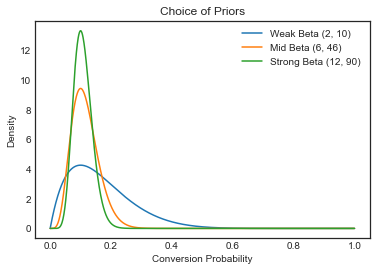

In [11]:
def beta_distribution(conversion_rate, value, return_all = False):
    prior_alpha = round(conversion_rate, 1)*value + 1
    prior_beta  = value + 1 - round(conversion_rate, 1)*value
    beta_dist   = beta(prior_alpha, prior_beta)
    if return_all: return beta_dist, prior_alpha, prior_beta
    else: return beta_dist

weak, mid, strong = 10, 50, 100
beta_weak         = beta_distribution(conversion_rate, weak)
beta_mid          = beta_distribution(conversion_rate, mid)
beta_strong       = beta_distribution(conversion_rate, strong)

fig, ax = plt.subplots(1, 1)

x = np.linspace(0,1,1000)

def plot_distribution(ax, x, y, conversion_rate, value, label):
    label = f'{label} Beta ({int(round(conversion_rate, 2)*value) + 1}, {value + 1 - int(round(conversion_rate, 2)*value)})'
    ax.plot(x, y.pdf(x), label = label)

plot_distribution(ax, x, beta_weak, conversion_rate, weak, "Weak")
plot_distribution(ax, x, beta_mid, conversion_rate, mid, "Mid")
plot_distribution(ax, x, beta_strong, conversion_rate, strong, "Strong")

ax.set_xlabel('Conversion Probability')
ax.set_ylabel('Density')
ax.set_title('Choice of Priors')
ax.legend()

plt.show()

All three distributions have a mean conversion rate of ~11%. However the **Strong Beta** is stronger than the true distribution.

We want a weaker prior and should therefore choose a prior that is inbetween the weak and mid beta.

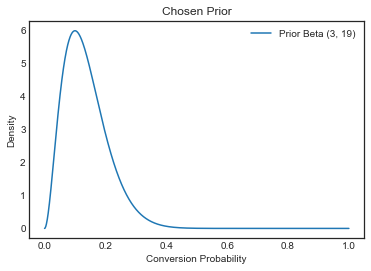

In [12]:
beta_value = 20

prior, prior_alpha, prior_beta = beta_distribution(conversion_rate, beta_value, return_all=True)

fig, ax = plt.subplots(1, 1)
x = np.linspace(0,1,1000)

plot_distribution(ax, x, prior, conversion_rate, beta_value, "Prior")

ax.set_xlabel('Conversion Probability')
ax.set_ylabel('Density')
ax.set_title('Chosen Prior')
ax.legend()
plt.show()

### Setting a loss threshold

Now that we have our prior, we need to decide the highest expected loss that we’re willing to accept in the case where we mistakenly choose the wrong variant. 

As this is an important conversion for us, we want to be pretty conservative with this.  We aren’t willing to accept a relative expected loss of more than 0.5% (0.005). So we set our loss threshold to **0.005 ∗ conversion_rate = 0.0005**.

In [13]:
loss_threshold = 0.005
expected_loss  = loss_threshold * conversion_rate

output_msg = "Our highest expected loss is: " + print2.bold(f"{round(expected_loss, 4)}", _print = False, _return = True)
print(output_msg)

Our highest expected loss is: 0.0005


### A/B Testing Results

We have a prior and a threshold for our expected loss, so we can start running our experiment and gathering data from it. We can now go ahead and aggregate the data.

In [14]:
results = df.reset_index().groupby('group').agg({'index': pd.Series.nunique, 'converted': sum})
results.rename({'index': 'sample_size'}, axis=1, inplace=True)
results['conversion_rate'] = results['converted']/results['sample_size']
print(results)

         sample_size  converted  conversion_rate
group                                           
A              10121       1151         0.113724
B              10121       1215         0.120047
C              10121       1139         0.112538
control        10121       1084         0.107104


We can tell by inspection that all three groups have had a better conversion rate than our control group, with Group B (no new images, but new treatment) performing the best.

However, how likely is this due to chance?  We need to perform further calculations in order to update our beliefs about the respective conversion probabilities.  We can calculate our posterior distributions under each variant. 

In [15]:
control = beta(prior_alpha + results.loc['control', 'converted'], prior_beta + results.loc['control', 'sample_size'] - results.loc['control', 'converted'])
A = beta(prior_alpha + results.loc['A', 'converted'], prior_beta + results.loc['A', 'sample_size'] - results.loc['A', 'converted'])
B = beta(prior_alpha + results.loc['B', 'converted'], prior_beta + results.loc['B', 'sample_size'] - results.loc['B', 'converted'])
C = beta(prior_alpha + results.loc['C', 'converted'], prior_beta + results.loc['C', 'sample_size'] - results.loc['C', 'converted'])

x = np.linspace(0.09,0.14,1000)

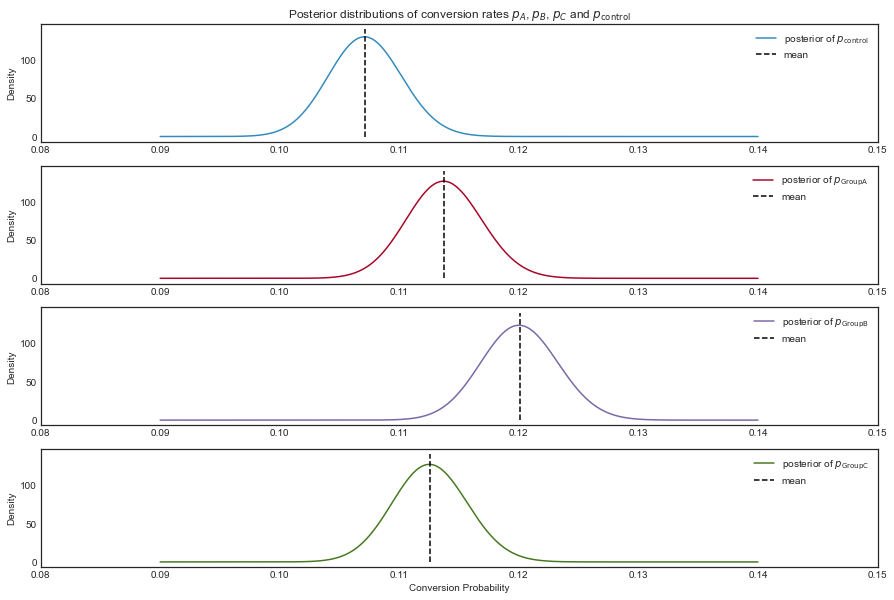

In [16]:
_, ax = plt.subplots(4, 1, figsize=(15, 10))
ax[0].set_title('Posterior distributions of conversion rates $p_A$, $p_B$, $p_C$ and $p_{\mathrm{control}}$')

for i in range(0,4): ax[i].set_xlim(0.08, 0.15)

ax[0].plot(x, control.pdf(x), label = 'posterior of $p_{\mathrm{' + "control" + '}}$', color = BMH_COLORS[0])
ax[0].vlines(control.mean(), 0, 140, color = "black",  linestyle = "--", label = "mean")


ax[1].plot(x, A.pdf(x), label = 'posterior of $p_{\mathrm{' + "Group A" + '}}$', color = BMH_COLORS[1])
ax[1].vlines(A.mean(), 0, 140, color = "black", linestyle = "--", label = "mean")

ax[2].plot(x, B.pdf(x), label = 'posterior of $p_{\mathrm{' + "Group B" + '}}$', color = BMH_COLORS[2])
ax[2].vlines(B.mean(), 0, 140, color = "black", linestyle = "--", label = "mean")

ax[3].plot(x, C.pdf(x), label = 'posterior of $p_{\mathrm{' + "Group C" + '}}$', color = BMH_COLORS[3])
ax[3].vlines(C.mean(), 0, 140, color = "black",  linestyle = "--", label = "mean")

for i in range(0,4): 
    ax[i].legend()
    ax[i].set_ylabel('Density')

ax[3].set_xlabel('Conversion Probability')


plt.show()

It appears that Group B has the best conversion rate.  In order to quantify this, we need to calculate the expected loss of wrongly choosing a treatment.

In [17]:
import decimal

def chance_of_beating_control(results, control, treatment, converted = "converted", sample_size = "sample_size", size = 10000, loss_threshold = 0.005):
    decimal.getcontext().prec = 4

    control_simulation   = np.random.beta(prior_alpha + results.loc[control, converted], prior_beta + results.loc[control, sample_size] - results.loc[control, converted], size=size)
    treatment_simulation = np.random.beta(prior_alpha + results.loc[treatment, converted], prior_beta + results.loc[treatment, sample_size] - results.loc[treatment, converted], size=size)
    treatment_won = [i <= j for i,j in zip(control_simulation, treatment_simulation)]
    chance_of_beating_control = np.mean(treatment_won)
    
    
    loss_control   = [max(j - i, 0) for i,j in zip(control_simulation, treatment_simulation)]
    loss_treatment = [max(i - j, 0) for i,j in zip(control_simulation, treatment_simulation)]
    
    all_loss_control   = [int(i)*j for i,j in zip(treatment_won, loss_control)]
    all_loss_treatment = [(1 - int(i))*j for i,j in zip(treatment_won, loss_treatment)]
    
    expected_loss_control   = np.mean(all_loss_control)
    expected_loss_treatment = np.mean(all_loss_treatment)
    expected_loss_treatment = decimal.getcontext().create_decimal(expected_loss_treatment)
    
    print2.bold(f'Chance of Group {treatment} beating control group is {decimal.getcontext().create_decimal(chance_of_beating_control)}')
    

    if expected_loss_treatment < loss_threshold:
        threshold_outcome = "below our loss threshold"
        highlight_color = print2.formatting.fg_color.bright_cyan
    else:
        threshold_outcome = "above our loss threshold"
        highlight_color = print2.formatting.fg_color.red
        
    print2.highlight(f"Expected loss of {round(expected_loss_treatment,6)} is {threshold_outcome}.",  
                     fg_color = highlight_color)

    print()


chance_of_beating_control(results, control = "control", treatment = "A", loss_threshold = expected_loss)
chance_of_beating_control(results, control = "control", treatment = "B", loss_threshold = expected_loss)
chance_of_beating_control(results, control = "control", treatment = "C", loss_threshold = expected_loss)

Chance of Group A beating control group is 0.9356
 Expected loss of 0.000115 is below our loss threshold. 

Chance of Group B beating control group is 0.9979
 Expected loss of 0.000002 is below our loss threshold. 

Chance of Group C beating control group is 0.8962
 Expected loss of 0.000222 is below our loss threshold. 



### Conclusion

Let's recall what Groups A, B C mean:

* user group **A**: saw the **new** version of the landing page, with **new** set of images.
* user group **B**: saw the **new** version of the landing page, with **old** set of images.
* user group **C**: saw the **old** version of the landing page, with **new** set of images.
* **Control** user group: saw the **old** version of both landing page and set of images.

So our conclusion from our testing is as so:

* **Best performing**: use the new landing page, but keep the old set of images;
* **Second best**: use both the new landing page and new set of images;
* **Third best**: use the new set of images, but keep the old landing page.
And each of them have more than 89% probability of being better than just using the old landing page and old set of images with a significantly low loss if we're wrong, that is below our threshold.

---
---

## Bringing this all together in one final visualistion

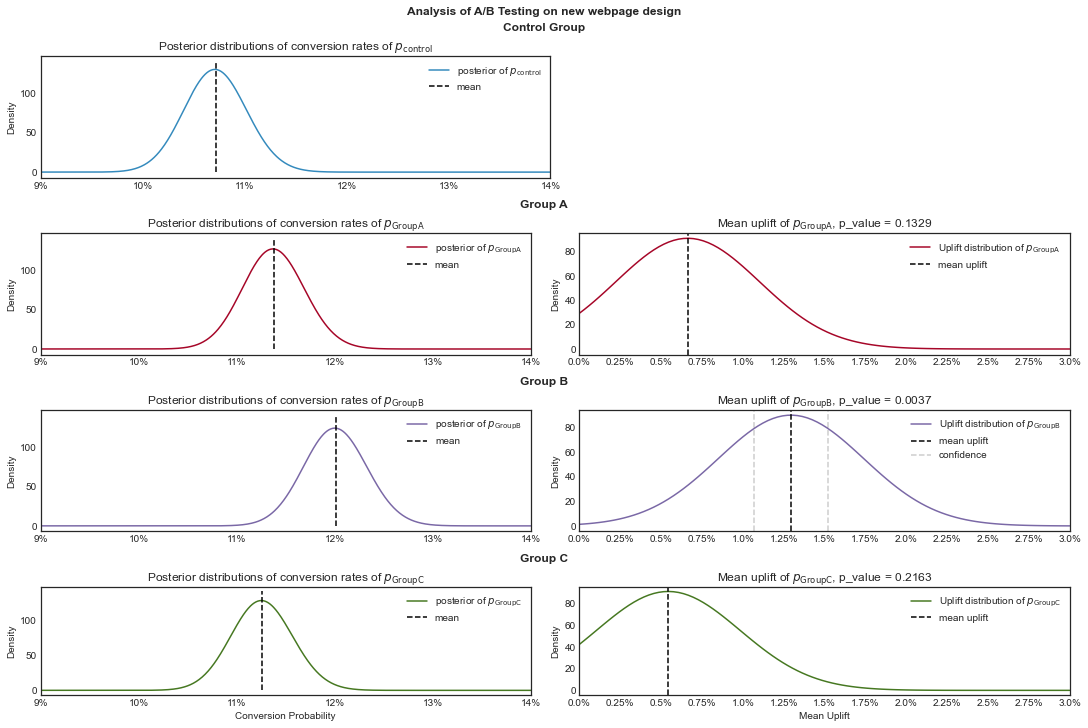

In [18]:
fig = plt.figure(constrained_layout=True, figsize = (15,10))
fig.suptitle("Analysis of A/B Testing on new webpage design",fontweight="bold")


# create 3x1 subfigs
subfigs = fig.subfigures(nrows=4, ncols=1)
subfigs[0].suptitle("Control Group",fontweight="bold")
subfigs[1].suptitle("Group A",fontweight="bold")
subfigs[2].suptitle("Group B",fontweight="bold")
subfigs[3].suptitle("Group C",fontweight="bold")



for row, subfig in enumerate(subfigs):
    axs = subfig.subplots(nrows=1, ncols=2)



ax = fig.get_axes()




# Bayesian 
x = np.linspace(0.08,0.14,1000)

ax[0].plot(x, control.pdf(x), label = 'posterior of $p_{\mathrm{' + "control" + '}}$', color = BMH_COLORS[0])
ax[0].vlines(control.mean(), 0, 140, color = "black",  linestyle = "--", label = "mean")
ax[0].set_title('Posterior distributions of conversion rates of $p_{\mathrm{control}}$')


ax[2].plot(x, A.pdf(x), label = 'posterior of $p_{\mathrm{' + "Group A" + '}}$', color = BMH_COLORS[1])
ax[2].vlines(A.mean(), 0, 140, color = "black", linestyle = "--", label = "mean")
ax[2].set_title('Posterior distributions of conversion rates of $p_{\mathrm{Group A}}$')



ax[4].plot(x, B.pdf(x), label = 'posterior of $p_{\mathrm{' + "Group B" + '}}$', color = BMH_COLORS[2])
ax[4].vlines(B.mean(), 0, 140, color = "black", linestyle = "--", label = "mean")
ax[4].set_title('Posterior distributions of conversion rates of $p_{\mathrm{Group B}}$')


ax[6].plot(x, C.pdf(x), label = 'posterior of $p_{\mathrm{' + "Group C" + '}}$', color = BMH_COLORS[3])
ax[6].vlines(C.mean(), 0, 140, color = "black",  linestyle = "--", label = "mean")
ax[6].set_title('Posterior distributions of conversion rates of $p_{\mathrm{Group C}}$')

for i in range(0,7,2): 
    ax[i].set_xlim(0.09, 0.14)
    ax[i].set_xticks(np.arange(.09, .15, 0.01))
    ax[i].set_xticklabels( ("9%", "10%", "11%", "12%", "13%", "14%") )

    ax[i].legend()
    ax[i].set_ylabel('Density')

ax[6].set_xlabel('Conversion Probability')




# Frequentist
x = np.linspace(0, 0.03, 100)

ax[1].set_visible(False)

data = statisical_tests(df[df.group == "control"].converted, df[df.group == "A"].converted)
generate_plot(ax[3], x, data, color = BMH_COLORS[1], group = "Group A")

data = statisical_tests(df[df.group == "control"].converted, df[df.group == "B"].converted)
generate_plot(ax[5], x, data, color = BMH_COLORS[2], group = "Group B")

data = statisical_tests(df[df.group == "control"].converted, df[df.group == "C"].converted)
generate_plot(ax[7], x, data, color = BMH_COLORS[3], group = "Group C")


for i in range(1,8,2): 
    ax[i].set_xlim(0.000, 0.030)
    ax[i].set_xticks(np.arange(.000, .031, 0.0025))
    ax[i].set_xticklabels( [str(round(_,3))+"%" for _ in np.arange(.000, .031, 0.0025)*100] )

#    ax[i].legend()
#    ax[i].set_ylabel('Density')

ax[7].set_xlabel(f"Mean Uplift")


###
plt.show()


